# Mapping evaluation

 - Human MTG data was integrated across 5 donors to create a `reference` with Azimuth
 - Cells from 84 donors were assigned labels using the Azimuth reference
 - Each of the 84 donors was treated as a separate `query` dataset
 - Azimuth- assigned labels are compared with scANVI- assigned labels (treating the latter as ground truth)

In [1]:
import feather
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

from sklearn.metrics import precision_recall_fscore_support as scores
from sklearn.metrics import confusion_matrix

sns.set()

In [2]:
result_path = "/home/rohan/Local/datasets/human_mtg_azimuth_eval/"

df_ref = feather.read_dataframe("/home/rohan/Local/datasets/MTG_AD_metadata_2022-04-13.feather")

df_list = []
file_gen = Path("/home/rohan/Local/datasets/human_mtg_query_results/").glob("*.feather")
df_qry = pd.concat([feather.read_dataframe(f) for f in file_gen])

print(f'Mapping {df_qry.shape[0]} cells across {df_qry["donor"].unique().shape[0]} donors')

Mapping 1089552 cells across 84 donors


In [3]:
df = df_qry.merge(df_ref, how='left', left_on='sample_id', right_on='sample_id')

df = df.rename(columns={'predicted.cluster': 'azimuth_cluster',
                        'predicted.subclass': 'azimuth_subclass',
                        'supertype_scANVI': 'scanvi_cluster',
                        "subclass_scANVI": "scanvi_subclass"})
df = df[['azimuth_cluster',
         'azimuth_subclass',
         'scanvi_cluster',
         "scanvi_subclass",
         "donor"]]

In [4]:
sc_lbl = np.sort(df['scanvi_subclass'].unique())
az_lbl = np.sort(df['azimuth_subclass'].unique())
print(f' unique to scanvi: {sc_lbl[~np.isin(sc_lbl, az_lbl)]}')
print(f' unique to azimuth: {az_lbl[~np.isin(az_lbl, sc_lbl)]}')

 unique to scanvi: ['Astro' 'Endo' 'Lamp5_Lhx6' 'Micro-PVM' 'Oligo']
 unique to azimuth: ['Astrocyte' 'Endothelial' 'Lamp5 Lhx6' 'Microglia-PVM' 'Oligodendrocyte']


In [5]:
# Some reference labels are different compared to the scanvi labels
azmith_scanvi_map = {'Astrocyte': 'Astro',
                     'Chandelier': 'Chandelier',
                     'Endothelial': 'Endo',
                     'Lamp5 Lhx6': 'Lamp5_Lhx6',
                     'Microglia-PVM': 'Micro-PVM',
                     'Oligodendrocyte': 'Oligo'}

for az_lbl, sc_lbl in azmith_scanvi_map.items():
    ind = df['scanvi_subclass']==sc_lbl
    df['scanvi_subclass'][ind] = az_lbl


In [6]:
# Some scanvi labels are absent from the reference label set.
sc_lbl = np.sort(df['scanvi_cluster'].unique())
az_lbl = np.sort(df['azimuth_cluster'].unique())
print(f'unique to scanvi: {sc_lbl[~np.isin(sc_lbl, az_lbl)]}')
print(f'unique to azimuth: {az_lbl[~np.isin(az_lbl, sc_lbl)]}')

unique to scanvi: ['Astro_5' 'Endo_1' 'Endo_3']
unique to azimuth: []


In [7]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=sorted(df['scanvi_cluster'].unique().tolist()), ordered=True)
df['scanvi_cluster'] = df['scanvi_cluster'].astype(cat_type)
df['azimuth_cluster'] = df['azimuth_cluster'].astype(cat_type)

cat_type = CategoricalDtype(categories=sorted(df['scanvi_subclass'].unique().tolist()), ordered=True)
df['scanvi_subclass'] = df['scanvi_subclass'].astype(cat_type)
df['azimuth_subclass'] = df['azimuth_subclass'].astype(cat_type)


In [8]:
# Helper functions
def get_scores(df_all):
    """get precision, recall and f1 scores.

    Args:
        df_all (pd.DataFrame): expects columns ['true', 'pred', 'donor'], each row is a single sample.
    
    Returns:
        result (pd.DataFrame) with scores and a column for support. 
    """
    result_df = []
    for donor in df_all['donor'].unique():
        df = df_all.loc[df_all['donor']==donor]
        p, r, f1, s = scores(df['true'], df['pred'],
                            labels=df['true'].cat.categories.to_list(),
                            average=None,
                            sample_weight=None,
                            zero_division=0)

        result = pd.DataFrame({'label': df['true'].cat.categories,
                            'precision': p,
                            'recall': r,
                            'f1': f1,
                            'support': s})
        result['donor']=donor
        result_df.append(result)
    result = pd.concat(result_df)
    return result


def plot_scores(df, figsize=(30,6)):
    f, ax = plt.subplots(1,1,figsize=figsize)
    ax = sns.barplot(data=df, x="label",y="precision",color="lightblue")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(xlabel='Cluster', ylabel='Precision')
    plt.show()

    f, ax = plt.subplots(1,1,figsize=figsize)
    ax = sns.barplot(data=df, x="label",y="recall",color="lightblue")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(xlabel='Cluster', ylabel='Recall')
    plt.show()
    return


def plot_confusion(df, figsize=(20,20)):
    """plot row-normalized confusion matrix

    Args:
        df (pd.DataFrame): expects columns ['true', 'pred', 'conf'], each row is a single sample.
    """
    
    label_list = df['true'].cat.categories.to_list()
    C = confusion_matrix(df['true'],
                        df['pred'],
                        labels=label_list,
                        normalize='true')
    C_df = pd.DataFrame(C, index=label_list, columns=label_list)
    C_df.index.name = 'True'
    C_df.columns.name = 'Pred'
    plt.subplots(1,1,figsize=figsize)
    ax = sns.heatmap(C_df,
                vmin=0,vmax=1,
                xticklabels=True, 
                yticklabels=True, 
                square=True, 
                linewidths=0.1,
                cmap=sns.color_palette("light:b", as_cmap=True),
                cbar_kws={'shrink': 0.3,"orientation": "vertical"})

    return C_df

In [9]:
# Get donor-wise and pooled results at subclass and cluster levels
df_subclass_all = df.copy()
df_subclass_all = df_subclass_all.rename(columns={'scanvi_subclass': 'true', 'azimuth_subclass': 'pred'})
df_subclass_all['donor'] = 'all' 
result_subclass_all = get_scores(df_subclass_all)

df_subclass_donorwise = df.copy()
df_subclass_donorwise = df_subclass_donorwise.rename(columns={'scanvi_subclass': 'true', 'azimuth_subclass': 'pred'})
result_subclass_donorwise = get_scores(df_subclass_donorwise)

df_cluster_all = df.copy()
df_cluster_all = df_cluster_all.rename(columns={'scanvi_cluster': 'true', 'azimuth_cluster': 'pred'})
df_cluster_all['donor'] = 'all' 
result_cluster_all = get_scores(df_cluster_all)

df_cluster_donorwise = df.copy()
df_cluster_donorwise = df_cluster_donorwise.rename(columns={'scanvi_cluster': 'true', 'azimuth_cluster': 'pred'})
result_cluster_donorwise = get_scores(df_cluster_donorwise)

## `Subclass level:`

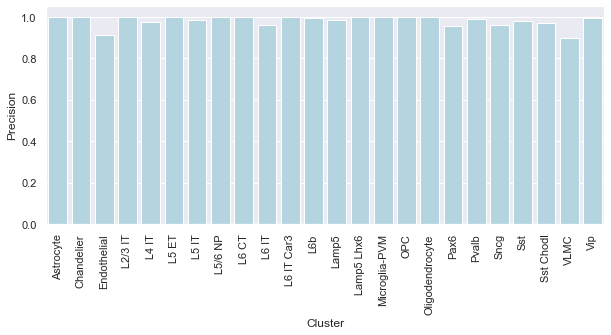

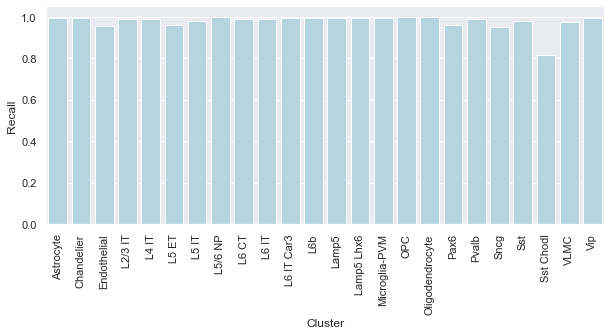

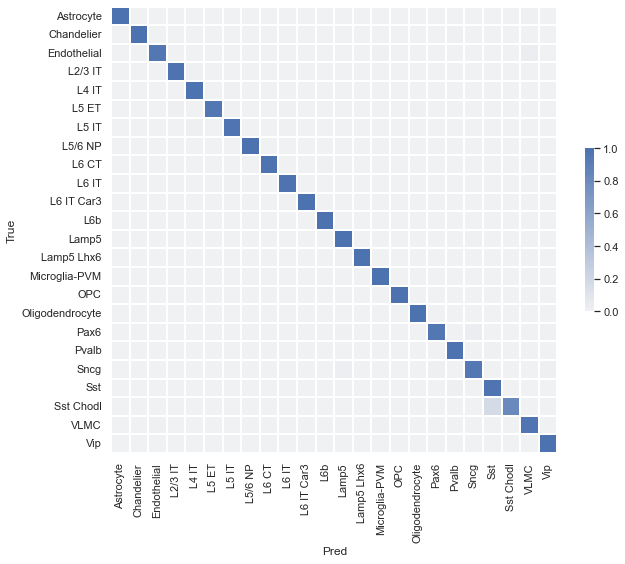

In [10]:
plot_scores(df=result_subclass_all, figsize=(10,4))
_ = plot_confusion(df=df_subclass_all, figsize=(10,10))

## `Cluster level:`

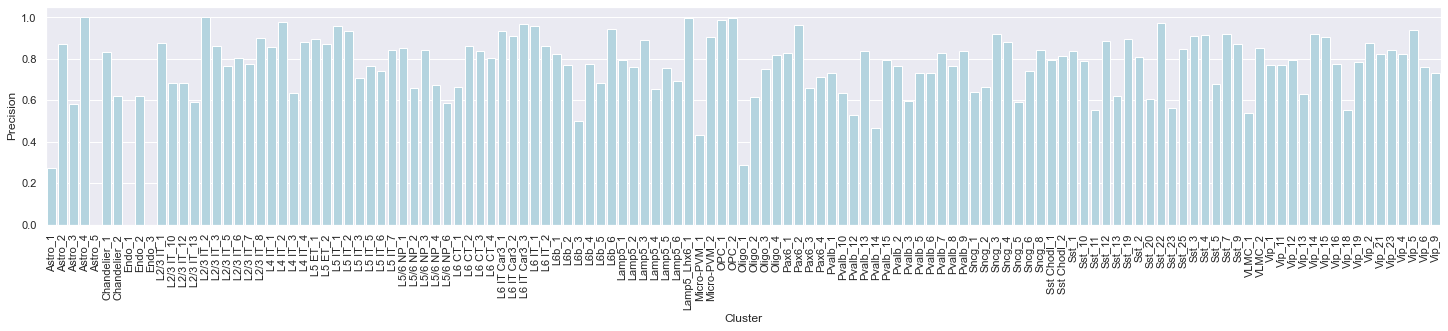

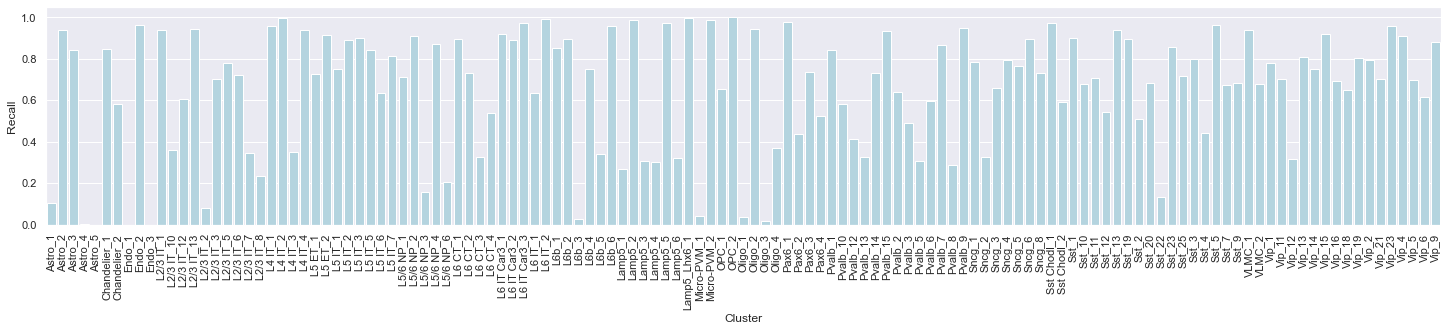

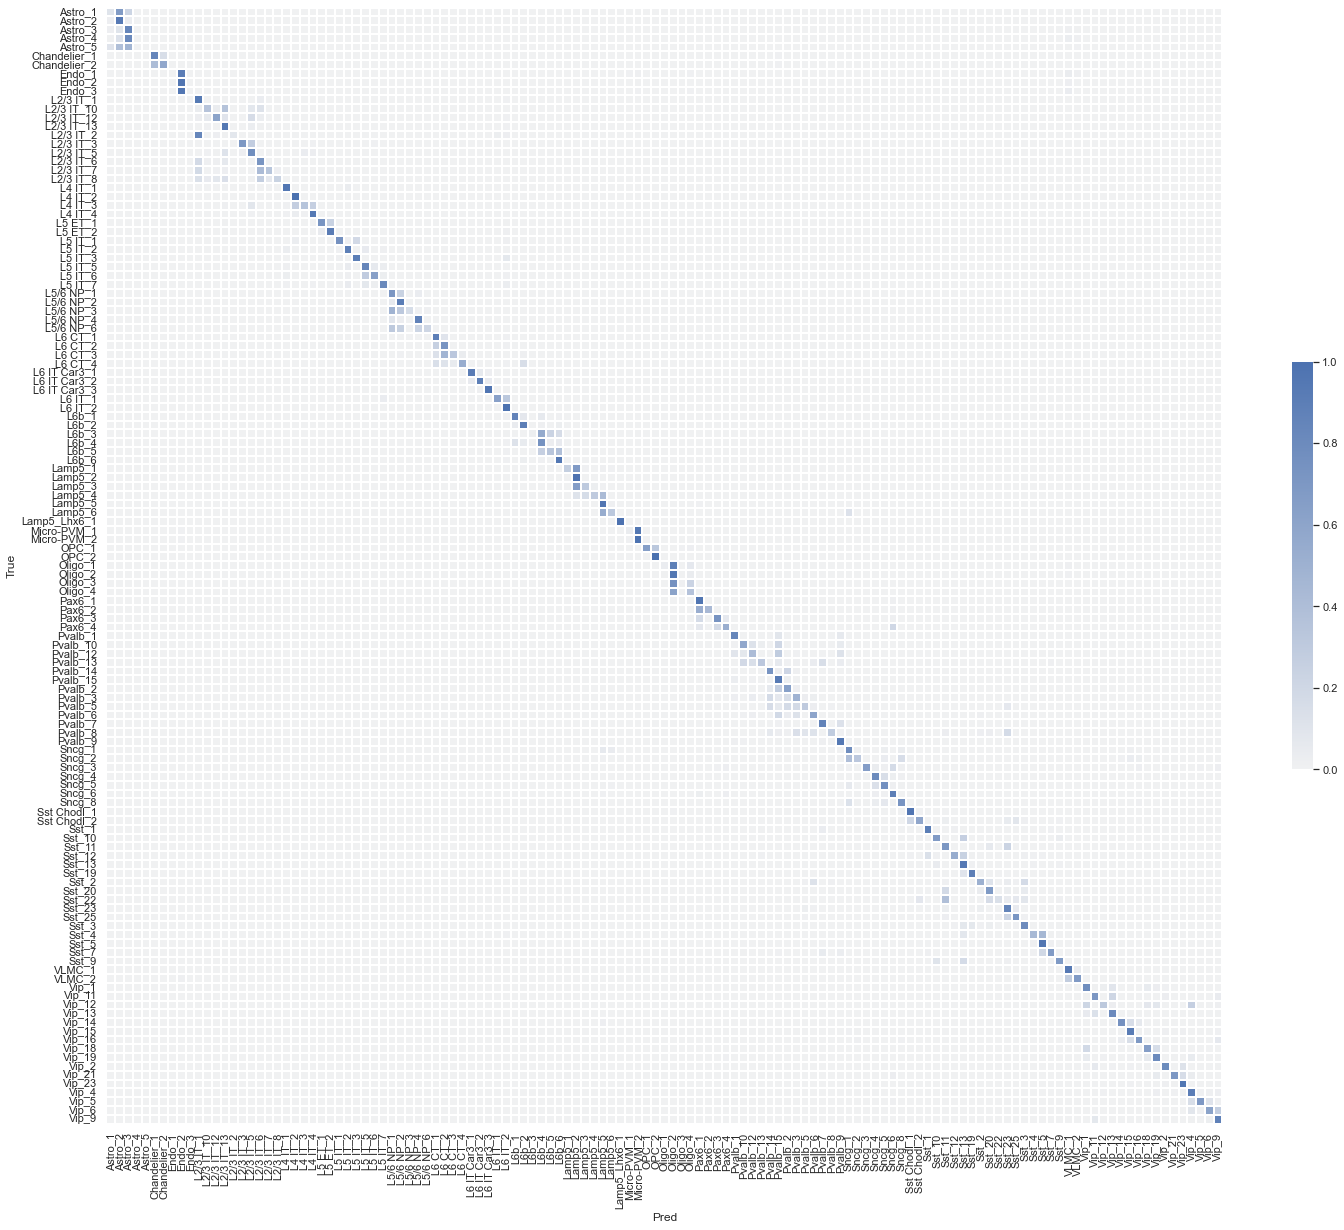

In [11]:
plot_scores(df=result_cluster_all, figsize=(25,4))
_ = plot_confusion(df=df_cluster_all, figsize=(25,25))

In [12]:
df.to_csv(result_path+'per_cell_mapping_result.csv')
df.head(2)

,azimuth_cluster,azimuth_subclass,scanvi_cluster,scanvi_subclass,donor
0,Oligo_2,Oligodendrocyte,Oligo_2,Oligodendrocyte,H20.33.036
1,L5 IT_1,L5 IT,L5 IT_1,L5 IT,H20.33.036


In [13]:
result_cluster_all.to_csv(result_path+'overall_cluster_metrics.csv')
result_cluster_all.head(2)

,label,precision,recall,f1,support,donor
0,Astro_1,0.273959,0.102980,0.149692,5302,all
1,Astro_2,0.870657,0.939941,0.903973,41909,all


In [14]:
result_cluster_donorwise.to_csv(result_path+'donorwise_cluster_metrics.csv')
result_cluster_donorwise.head(2)

,label,precision,recall,f1,support,donor
0,Astro_1,0.000000,0.0,0.000000,20,H20.33.036
1,Astro_2,0.915014,1.0,0.955621,323,H20.33.036


In [15]:
result_subclass_all.to_csv(result_path+'overall_subclass_metrics.csv')
result_subclass_all.head(2)

,label,precision,recall,f1,support,donor
0,Astrocyte,0.999680,0.993714,0.996688,59657,all
1,Chandelier,0.999563,0.993376,0.996460,9209,all


In [16]:
result_subclass_donorwise.to_csv(result_path+'donorwise_subclass_metrics.csv')
result_subclass_donorwise.head(2)

,label,precision,recall,f1,support,donor
0,Astrocyte,1.0,0.99726,0.998628,365,H20.33.036
1,Chandelier,1.0,1.00000,1.000000,32,H20.33.036
